# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
low_RAM_mode = False
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [3]:
import csv
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv(r"avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv(r"avito_train_1kk.tsv",sep='\t')
 

In [4]:
print(df.shape, df.is_blocked.mean())
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print("Blocked ratio", df.is_blocked.mean())
print("Blocked Count:", len(df[df.is_blocked == 0]))
print("Count:", len(df))

Blocked ratio 0.0688212106553
Blocked Count: 3720807
Count: 3995803


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [6]:
# downsample data so that both classes have approximately equal ratios>

n = int(round((1 - df.is_blocked.mean()) / df.is_blocked.mean()))
df = pd.concat([df[df.is_blocked == 1], df[df.is_blocked == 0].iloc[::n, :]])

print("Blocked ratio:", df.is_blocked.mean())
print("Count:", len(df))

Blocked ratio: 0.50852861116
Count: 540768


In [7]:
assert(df.is_blocked.mean() < 0.51)
assert(df.is_blocked.mean() > 0.49)
assert(len(df) <= 560000)

print("All tests passed")

All tests passed


# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [8]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter, defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values, df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

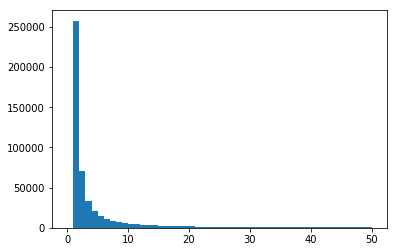

In [9]:
#Word frequency distribution, just for kicks
_ = plt.hist(list(token_counts.values()), range=[0,50], bins=50)

In [10]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [k for k, v in token_counts.items() if v >= min_count]

In [11]:
token_to_id = {t: i+1 for i, t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [12]:
print("# Tokens before:", len(token_counts))
print("# Tokens after filtering:", len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) > 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doing, ofc")

# Tokens before: 516253
# Tokens after filtering: 87072


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples] x [max_length]
 * Element at i, j - is an identifier of word j within sample i

In [13]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0] * max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token, 0), tokens))[:max_len]
        token_ids += [0] * (max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [14]:
desc_tokens = vectorize(df.description.values, token_to_id, max_len = 150)
title_tokens = vectorize(df.title.values, token_to_id, max_len = 15)

### Data format examples


In [15]:
print("Размер матрицы:", title_tokens.shape)
for title, tokens in zip(df.title.values[:3], title_tokens[:3]):
    print(title, '->', tokens[:10], '...')

Размер матрицы: (540768, 15)
Поездки на таможню, печать в паспорте -> [82315 37963 17853 74611 86214  2079     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 5907     0 19997     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [ 6350 30033     0 37412 58617     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [16]:
# All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [17]:
# One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

data_cat_subcat = df[["category","subcategory"]].values

# A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample
categories = [{"category": v[0], "subcategory": v[1]} for v in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot, columns=vectorizer.feature_names_)

In [18]:
df_non_text = pd.merge(
    df_numerical_features, cat_one_hot, on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [19]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [20]:
#Split into training and test set.

#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard


from sklearn.model_selection import train_test_split
title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(
    title_tokens, desc_tokens, df_non_text, target, test_size=0.2, random_state=17)

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [21]:
#libraries
import lasagne
from theano import tensor as T
import theano

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.4/site-packages/Theano-0.8.2-py3.4.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [61]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids", dtype='int32')
desc_token_ids = T.matrix("desc_token_ids", dtype='int32')
categories = T.matrix("categories", dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [62]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [63]:
# Descriptions

HIDDEN_UNITS = 64
GRAD_CLIP = 100

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_emb = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=128)
descr_lstm = lasagne.layers.LSTMLayer(descr_emb, HIDDEN_UNITS, grad_clipping=GRAD_CLIP)
descr_lstm_flat = lasagne.layers.FlattenLayer(descr_lstm)

# Titles
title_emb = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=128)
title_lstm = lasagne.layers.LSTMLayer(title_emb, HIDDEN_UNITS, grad_clipping=GRAD_CLIP)
title_lstm_flat = lasagne.layers.FlattenLayer(title_lstm)

# Non-sequences
cat_dense_1 = lasagne.layers.DenseLayer(cat_inp, num_units=64, nonlinearity=lasagne.nonlinearities.leaky_rectify)
cat_drop = lasagne.layers.DropoutLayer(cat_dense_1)
cat_dense_2 = lasagne.layers.DenseLayer(cat_drop, num_units=64, nonlinearity=lasagne.nonlinearities.leaky_rectify)

In [64]:
# merge three layers into one (e.g. lasagne.layers.concat)
l_concat = lasagne.layers.concat([descr_lstm_flat, title_lstm_flat, cat_dense_2])  

l_dense = lasagne.layers.DenseLayer(l_concat, 1024)
l_dropout = lasagne.layers.DropoutLayer(l_dense, p=0.05)
dense_output = lasagne.layers.DenseLayer(l_dropout, 1, nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [65]:
#All trainable params
weights = lasagne.layers.get_all_params(dense_output, trainable=True)

#Simple NN prediction
prediction = lasagne.layers.get_output(dense_output)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta=1.0, log_odds=True).mean()
loss += 1e-5 * lasagne.regularization.regularize_layer_params(
        [descr_lstm, title_lstm, cat_dense_2, l_dense], 
        lasagne.regularization.l2
    )
#Weight optimization step
initial_lr = 0.01
sh_lr = theano.shared(lasagne.utils.floatX(initial_lr))
updates = lasagne.updates.adam(loss, params=weights, learning_rate=sh_lr)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [66]:
#deterministic version
det_prediction = lasagne.layers.get_output(dense_output, deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction, target_y, delta=1.0, log_odds=True).mean()
det_loss += 1e-5 * lasagne.regularization.regularize_layer_params(
        [descr_lstm, title_lstm, cat_dense_2, l_dense], 
        lasagne.regularization.l2
    )

### Coffee-lation

In [67]:
train_fun = theano.function([desc_token_ids, title_token_ids, categories, target_y], [loss, prediction], updates=updates)
eval_fun = theano.function([desc_token_ids, title_token_ids, categories, target_y], [det_loss, det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [68]:
#average precision at K

from oracle import APatK, score

In [69]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays, **kwargs):
    batchsize=kwargs.get("batchsize", 100)
    shuffle = kwargs.get("shuffle", True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [70]:
from sklearn.metrics import roc_auc_score, accuracy_score
import time

n_epochs = 50
batch_size = 164
minibatches_per_epoch = 1000

for i in range(n_epochs):
    start_time = time.time()
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr, title_tr, nontext_tr.as_matrix(), target_tr, batchsize=batch_size, shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss, pred_probas = train_fun(b_desc, b_title, b_cat, b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("n_epoch:\t{}".format(i))
    print("Train:")
    print('\tloss:', b_loss/b_c)
    print('\tacc:', accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:', roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:', APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts, title_ts, nontext_tr.as_matrix(), target_ts, batchsize=batch_size, shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    print("Val:")
    print('\tloss:', b_loss/b_c)
    print('\tacc:', accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:', roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:', APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    if (i + 1) % 5 == 0:
        learning_rate = sh_lr.get_value()
        learning_rate *= 0.32
        print("new_lr:{}".format(learning_rate))
        sh_lr.set_value(lasagne.utils.floatX(learning_rate))
    print("time spent:{}".format(time.time() - start_time))

n_epoch:	0
Train:
	loss: 597.318714241
	acc: 0.831022635901
	auc: 0.859231996787
	ap@k: 0.337125655038
Val:
	loss: 1.65998297632
	acc: 0.840824975018
	auc: 0.915107416445
	ap@k: 0.997366145613
time spent:184.71901679039001
n_epoch:	1
Train:
	loss: 1.44198791225
	acc: 0.906569040715
	auc: 0.938910910438
	ap@k: 0.978793737512
Val:
	loss: 0.620406056595
	acc: 0.869517746771
	auc: 0.920205765051
	ap@k: 0.997549042435
time spent:185.48784565925598
n_epoch:	2
Train:
	loss: 0.377688922724
	acc: 0.926080017543
	auc: 0.950487769247
	ap@k: 0.991618348646
Val:
	loss: 0.559623729898
	acc: 0.812881675858
	auc: 0.829523388841
	ap@k: 0.996560902506
time spent:186.7937560081482
n_epoch:	3
Train:
	loss: 0.304021805758
	acc: 0.925787627007
	auc: 0.946531549449
	ap@k: 0.989475327168
Val:
	loss: 0.444478763171
	acc: 0.835495392131
	auc: 0.874994140401
	ap@k: 0.997615429525
time spent:186.74020719528198
n_epoch:	4
Train:
	loss: 0.364381064444
	acc: 0.882934139032
	auc: 0.901652030617
	ap@k: 0.998722192615


KeyboardInterrupt: 

In [71]:
print("If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. ")

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [72]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc, b_title, b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts, title_ts, nontext_tr.as_matrix(), target_ts, batchsize=batch_size, shuffle=True)):
    loss,pred_probas = eval_fun(b_desc, b_title, b_cat, b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true, epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true, epoch_y_pred)
final_apatk = APatK(epoch_y_true, epoch_y_pred, K = int(len(epoch_y_pred)*0.025)+1)

print("Scores:")
print('\tloss:', b_loss/b_c)
print('\tacc:', final_accuracy)
print('\tauc:', final_auc)
print('\tap@k:', final_apatk)
score(final_accuracy, final_auc, final_apatk)

Scores:
	loss: 0.234091943351
	acc: 0.910933047115
	auc: 0.930724345809
	ap@k: 0.999445624337

AUC:
	Неплохо, но ты можешь лучше! (not ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.